# Exploring Ocean Temperature Change
In this notebook we are exploring the change in ocean temperature at specific location in the ocean.
- Data from the 1980s until today is downloaded from the Ocean Data Platform
- The casts are interpolated individually to obtain temperature measurements at the same depth intervals
- The temperature measurements are then interpolated in space and time to obtain a temperature time series at each location
- The time histories are analyzed to explore temperature increase and change in seasonal variations.

In [1]:


import calendar 
import cmocean
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from CasstFunctions import *
from dateutil.relativedelta import *

warnings.filterwarnings("ignore")





from odp_sdk import ODPClient
client = ODPClient(api_key='xxxxxxxxxxxxxx')

Connected


In [2]:
# Location of Interpolation - Skakerrak
point_lat=58
point_lon=10
ddeg=2 #buffer

# Downloading data from ODP
measurements=client.casts(longitude=[point_lon-ddeg,point_lon+ddeg],
                latitude=[point_lat-ddeg,point_lat+ddeg],
                timespan=['1980-01-01','2020-01-01'],
                parameters=['date','lon','lat','z','Temperature'],
                include_flagged_data=False,
                n_threads=45)

Locating available casts..
-> 47801 casts found
-> 1513892 data rows downloaded in 302.45s


In [3]:
measurements.head()

,externalId,datetime,date,lon,lat,z,Temperature
0,cast_wod_3_1980_34527_7530698,1980-07-24,19800724,11.683333,57.0,21.796791,14.49
1,cast_wod_3_1980_34527_7530698,1980-07-24,19800724,11.683333,57.0,22.787498,14.38
2,cast_wod_3_1980_34527_7530698,1980-07-24,19800724,11.683333,57.0,23.778202,14.22
3,cast_wod_3_1980_34527_7530698,1980-07-24,19800724,11.683333,57.0,24.768900,14.15
4,cast_wod_3_1980_34527_7530698,1980-07-24,19800724,11.683333,57.0,25.759594,14.04


In [4]:
# Interpolating each temperature profile. OBS: This one takes a long time.
measurements_int=interpolate_casts_to_z(measurements[measurements.z<50].dropna(),'Temperature',[0,2,5,10,20,40]) 

In [5]:
measurements_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272262 entries, 0 to 272261
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   externalId   272262 non-null  object        
 1   datetime     272262 non-null  datetime64[ns]
 2   lon          272262 non-null  float64       
 3   lat          272262 non-null  float64       
 4   z            272262 non-null  float64       
 5   Temperature  221527 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 12.5+ MB


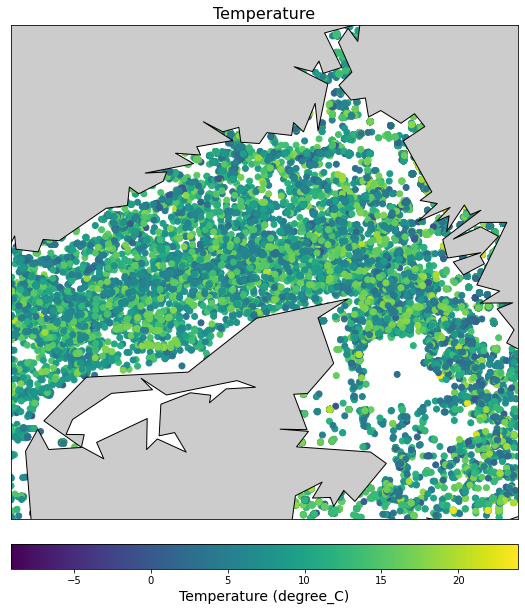

In [6]:
plot_casts('Temperature',measurements_int[measurements_int.z==5])

In [66]:


df=measurements_int[measurements_int.z==5].copy()
df.dropna(inplace=True)
kind='rbf'
days_buffer=60
variable='Temperature'
#deg_buffer=5

dt=pd.Timedelta(days=days_buffer)

time_hist=[]
temp_hist=[]
for month in range(12*40):
    
    int_time=pd.to_datetime('1980-01-01')+relativedelta(months=month)

    num_days = calendar.monthrange(int_time.year, int_time.month)[1]
    int_days = [(pd.datetime(int_time.year, int_time.month, day)-pd.datetime(1970,1,1)).total_seconds() for day in range(1, num_days+1)]
  
    int_points=[[point_lon],[point_lat], int_days]
    
    _df=df[(df.datetime>(int_time-dt-pd.Timedelta(days=15))) & (df.datetime<(int_time+dt-pd.Timedelta(days=15)))]
    _df['unixtime']=_df['datetime'] - pd.datetime(1970,1,1)
    _df['unixtime']=_df['unixtime'].apply(lambda x : x.total_seconds())

    if _df.empty:
        continue
    if _df.shape[0]<10:
        continue
    
    points=_df[['lon','lat','unixtime']].values.astype('float')
    values=_df['Temperature'].values.astype('float')
    
    grid,g=interpolate_to_grid(points.copy(),values.copy(),int_points, interp_type=kind,rescale=True,
                               rbf_smooth=1e-5)
    
    time_hist+=int_days
    temp_hist+=g[0,0].tolist()


In [67]:
_df.shape

(0, 7)

In [68]:
df=pd.DataFrame(np.vstack([[time_hist],[temp_hist]]).T,columns=['time','temperature'])
df['datetime']=df['time'].apply(lambda d : pd.Timestamp(1970,1,1)+pd.Timedelta(seconds=d))#pd.to_datetime(df['time'],unit='s')
df.set_index('datetime',inplace=True)
df.dropna(inplace=True)
df.sort_index(inplace=True)
df.head(10)

,time,temperature
datetime,,
1980-01-01,315532800.0,3.911582
1980-01-02,315619200.0,3.936749
1980-01-03,315705600.0,3.963830
1980-01-04,315792000.0,3.992661
1980-01-05,315878400.0,4.022950
1980-01-06,315964800.0,4.054240
1980-01-07,316051200.0,4.085857
1980-01-08,316137600.0,4.116851
1980-01-09,316224000.0,4.145949


## Historic Temperature History and Trend

Mean temperature change of 1.46 degrees between 1981 and 2019


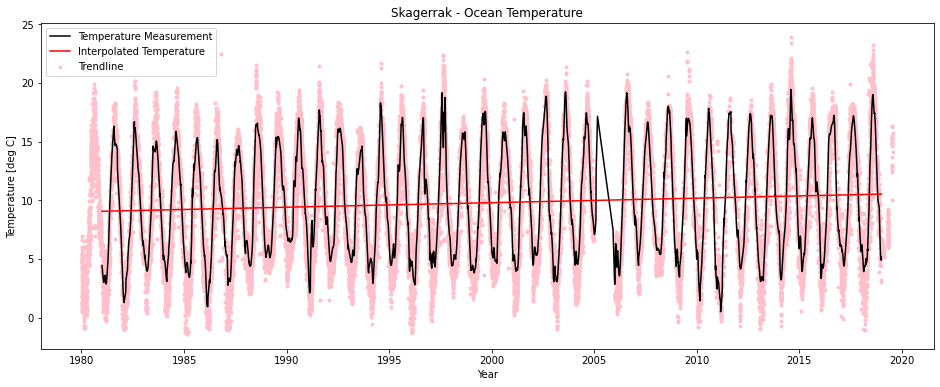

In [74]:
_df=df['1981-01-01':'2019-01-01']

x=(_df.index-pd.Timestamp(1980,1,1)).days
y=_df['temperature']

z = np.polynomial.polynomial.polyfit(x,y, 1) 


y=z[0]+z[1]*(x-x[0])

plt.figure(figsize=(16,6))
plt.scatter(measurements_int[measurements_int.z==5].datetime,measurements_int[measurements_int.z==10].Temperature,marker='.',color='pink')
plt.plot(_df.index,_df.temperature,'k')
plt.plot(_df.index,y,'r')
plt.xlabel('Year')
plt.ylabel('Temperature [deg C]')
plt.title('Skagerrak - Ocean Temperature')

plt.legend(['Temperature Measurement','Interpolated Temperature','Trendline'],loc=0)
print('Mean temperature change of %.2f degrees between %s and %s'%(z[1]*(x[-1]-x[0]),_df.index[0].year,_df.index[-1].year))

## Annual Variation - Standard Deviation of Sea Surface Temperatures

Annual temperature std has increased by 18% from 1981 to 2018


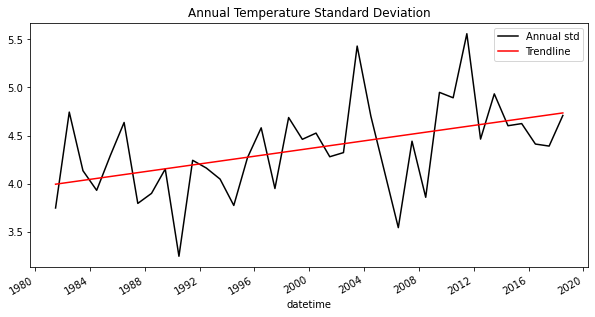

In [70]:
temp_std=_df.rolling('360d',).std()[_df.index.dayofyear==6*30+3]
temp_std.temperature.plot(figsize=(10,5),color='k');plt.title('Annual Temperature Standard Deviation')

z = np.polynomial.polynomial.polyfit(temp_std.index.year.values,temp_std.temperature.values, 1)
r=z[0]+z[1]*temp_std.index.year.values
plt.plot(temp_std.index,r,'r')
plt.legend(['Annual std','Trendline'],loc=0)
print('Annual temperature std has increased by %d%% from %d to %d'%((r[-1]/r[0]-1)*100,temp_std.index.year.values[0],temp_std.index.year.values[-1]))

### July Mean Surface Temperature

July temperarue has increased by 2.0 degrees between 1981 and 2018


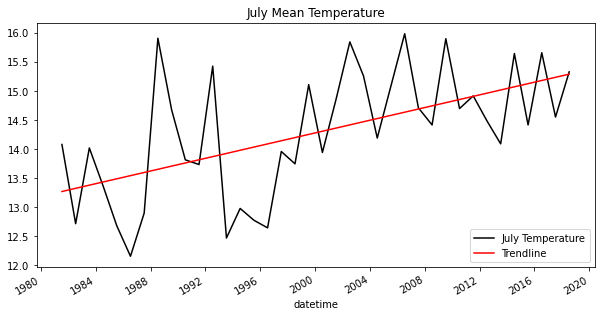

In [71]:
temp_mean_july=_df.rolling('30d',).mean()[_df.index.dayofyear==6*30+15]
temp_mean_july.temperature.plot(figsize=(10,5),color='k');plt.title('July Mean Temperature')

z = np.polynomial.polynomial.polyfit(temp_mean_july.index.year.values,temp_mean_july.temperature.values, 1)
r=z[0]+z[1]*temp_mean_july.index.year.values
plt.plot(temp_mean_july.index,r,'r')
plt.legend(['July Temperature','Trendline'],loc=0)
print('July temperarue has increased by %.1f degrees between %d and %d'%(r[-1]-r[0],temp_mean_july.index.year.values[0],temp_mean_july.index.year.values[-1]))